# PID controller

Python notebook simulating [proportional–integral–derivative (PID) controller](https://en.wikipedia.org/wiki/PID_controller).

In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

sns.set_style('darkgrid')
%matplotlib inline
np.random.seed(42)

Simulate object moving in 1D space with a gravity acceleration in the negative direcction where control is applied as acceleration.

* $x$ is the position of the object
* $v$ is the velocity of the object
* $a$ is the applied control acceleration of the object
* $t$ is the timestep.
* $g$ is the gravity (constant)

$$
\Delta{x(t)} = v(t)\Delta{t} + \frac{1}{2} a(t) \Delta{t}^2 + g
$$

We will simulate with timesteps $\Delta{t}=1$ in the examples below.


The error $e(t)$ of the control problem will be the difference of the target with the object's position at timestep $t$. ($target=0$ in these examples):

$$
e(t) = target - x(t)
$$

In [2]:
class MovingObject1D:
    def __init__(self, x=0., v=0., g=-1.):
        """Object moving in 1D space"""
        self.x = x  # Position
        self.v = v  # Velocity
        self.g = g  # Gravity
        
    def update(self, a=0.):
        """
        Update for 1 timestep.
        
        Args:
            a (float): acceleration applied during update.
        """
        # Update velocity by acceleration from control and gravity
        dv = 0.5*(a + self.g)
        self.v += dv
        # Update position by velocity
        dx = self.v
        self.x += dx

## Proportional controller

The P in PID stands for "proportional" and will apply a control signal (acceleration) proportional to the error.

$$
a(t) = K_p e(t)
$$

With $K_p$ the amount of proportional control.

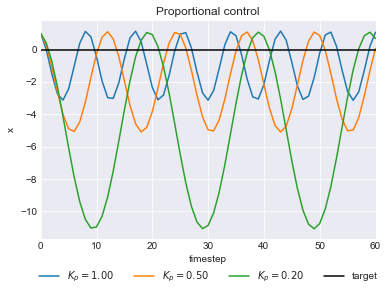

In [3]:
def simulate_p(n, kp):
    """Simulate proportional controller"""
    obj = MovingObject1D(x=1, v=0, g=-1)
    target = 0.
    xs = [obj.x]
    # Simulate timesteps
    for i in range(n):
        error = target - obj.x
        # Proportional control
        a = kp * error
        obj.update(a)
        xs.append(obj.x)
    return xs


# Simulate and plot for different control parameters
plt.figure()
n = 60
for kp in [1, 0.5, 0.2]:
    xs = simulate_p(n=n, kp=kp)
    plt.plot(xs, label='$K_p = {:.2f}$'.format(kp))
plt.plot((0,n), (0, 0), color='black', label='target')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=4)
plt.xlim((0,n))
plt.xlabel('timestep')
plt.ylabel('x')
plt.title('Proportional control')
plt.show()

## Proportional-Derivative control

To dampen the oscillations of the proportional control a derivative control term can be added. This term will apply a control signal (acceleration) proportional to the derivative of the error term:


$$
a(t) = K_p e(t) + K_d \Delta e(t)
$$


With $K_d$ the amount of derivative control.

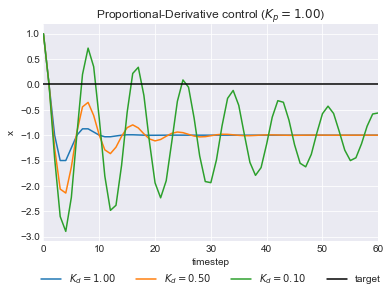

In [4]:
def simulate_pd(n, kp, kd):
    """Simulate proportional derivative controller"""
    obj = MovingObject1D(x=1, v=0, g=-1)
    target = 0.
    xs = [obj.x]
    prev_error = target - obj.x
    for i in range(n):
        error = target - obj.x
        derror = error - prev_error  # Derivative of error
        # Proportional control signal
        ap = kp * error
        # Derivative control signal
        ad = kd * derror
        # Total control signal
        a = ap + ad
        obj.update(a)
        xs.append(obj.x)
        prev_error = error
    return xs


# Simulate and plot for different control parameters
plt.figure()
kp = 1
n = 60
for kd in [1, 0.5, 0.1]:
    xs = simulate_pd(n=n, kp=kp, kd=kd)
    plt.plot(xs, label='$K_d = {:.2f}$'.format(kd))
plt.plot((0,n), (0, 0), color='black', label='target')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=4)
plt.xlim((0, n))
plt.xlabel('timestep')
plt.ylabel('x')
plt.title('Proportional-Derivative control ($K_p = {:.2f}$)'.format(kp))
plt.show()

## Proportional-Integral-Derivative control

To correct for the constant gravity bias and to actually bring the position close to the target we need an accumulating error term that will accumulate a constant error over time. This is done by the integral term. The full PID equation becomes:

$$
a(t) = K_p e(t) + K_i \sum e(t) + K_d \Delta e(t)
$$

With $K_i$ the amount of integral control.

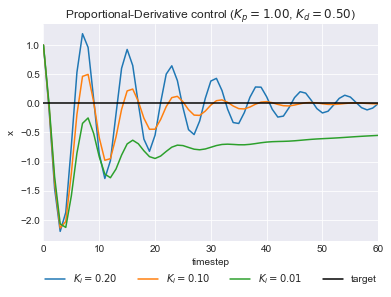

In [5]:
def simulate_pid(n, kp, ki, kd):
    """Simulate proportional-integral-derivative controller"""
    obj = MovingObject1D(x=1, v=0, g=-1)
    target = 0.
    xs = [obj.x]  # List of postions over time
    es = [target - obj.x]  # List of errors over time
    error_sum = 0.
    for i in range(n):
        error = target - obj.x
        es.append(error)
        derror = es[i+1] - es[i]  # Derivative of error
        error_sum += error  # Integral of error
        # Proportional control signal
        ap = kp * error
        # Integral control signal
        ai = ki * error_sum
        # Derivative control signal
        ad = kd * derror
        # Total control signal
        a = ap + ai + ad
        obj.update(a)
        xs.append(obj.x)
    return xs, es


# Simulate and plot for different control parameters
plt.figure()
kp = 1
kd = 0.5
n = 60
for ki in [0.2, 0.1, 0.01]:
    xs, _ = simulate_pid(n=n, kp=kp, ki=ki, kd=kd)
    plt.plot(xs, label='$K_i = {:.2f}$'.format(ki))
plt.plot((0,n), (0, 0), color='black', label='target')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=4)
plt.xlim((0,n))
# plt.ylim((0.2,-0.2))
plt.xlabel('timestep')
plt.ylabel('x')
plt.title('Proportional-Derivative control ($K_p = {:.2f}$, $K_d = {:.2f}$)'.format(kp, kd))
plt.show()

## Optimize the PID control parmeters

Based on the [Twiddle](https://www.youtube.com/watch?v=2uQ2BSzDvXs) algorithm as explained by Udacity.

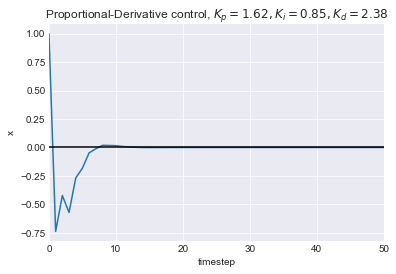

In [6]:
def score(es):
    # Score is quadratic error of all observations
    return sum([e**2 for e in es]) / len(es)


def parameter_optimization(tol=0.1): 
    n = 500  # Number of updates in the simulation
    k = [0., 0., 0.]  # Parameters
    dk = [1., 1., 1.]  # Relative updates
    # Run experiment with initial paramters
    xs, es = simulate_pid(n=n, kp=k[0], ki=k[1], kd=k[2])
    best_err = score(es)
    while sum(dk) > tol:
        # for each parameter
        for i in range(len(k)):
            k[i] += dk[i]
            xs, es = simulate_pid(n=n, kp=k[0], ki=k[1], kd=k[2])
            err = score(es)
            if err < best_err:  # New best error found
                best_err = err
                dk[i] *= 1.1
            else:  # No improvement
                k[i] -= 2 * dk[i]  # Change direction
                xs, es = simulate_pid(n=n, kp=k[0], ki=k[1], kd=k[2])
                err = score(es)
                if err < best_err:  # New best error found
                    best_err = err
                    dk[i] *= 1.1
                else:  # No improvement, reduce step size
                    k[i] += dk[i]
                    dk[i] *= 0.90
    return k


k = parameter_optimization()
n = 50
xs, _ = simulate_pid(n=n, kp=k[0], ki=k[1], kd=k[2])
plt.plot(xs)
plt.plot((0,n), (0, 0), color='black', label='target')
plt.xlim((0,n))
plt.xlabel('timestep')
plt.ylabel('x')
plt.title(
    'Proportional-Derivative control, $K_p={:.2f}, K_i={:.2f}, K_d={:.2f}$'.format(
        *k))
plt.show()